In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import cos, sin, pi, e, sqrt, atan2
from PGM import PGMImage

In [1]:
def mag(a_b: complex):
    """ Equivalent to np.abs; takes in a single complex. """
    return sqrt( (a_b.real ** 2) + (a_b.imag ** 2))

def phase(a_b: complex):
    """ Equivalent to np.angle; takes in a single complex. """
    return atan2(a_b.imag, a_b.real)

In [24]:
!tail -n +1 Makefile fft.c

==> Makefile <==
lib:
	gcc -Wall -shared -o fft.so -fPIC fft.c

==> fft.c <==
/* 

   The real part is stored in the odd locations of the array
   (data[1], data[3], data[5]. etc) and the imaginary part 
   in the even locations (data[2], data[4], data[6], etc. 

   The elements in the array data must be stored from data[1] 
   to data[2*nn] -  data[0] is not used!  To call fft, use the
   following:  fft(data-1,N,isign);
 
   nn is the length of the input which should be power of 2. 

   isign: -1 Forward FFT, isign: 1  Inverse FFT (based on our definition)
   
   factor 1/N that appears in the forward DFT equation; you should do this 
   yourself (see page 506 from the fft handout).

*/
   

#include <math.h>
#define SWAP(a,b) tempr=(a);(a)=(b);(b)=tempr

void fft(float data[], unsigned long nn, int isign)
{
	unsigned long n,mmax,m,j,istep,i;
	double wtemp,wr,wpr,wpi,wi,theta;
	float tempr,tempi;

	n=nn << 1;
	j=1;
	for (i=1;i<n;i+=2) {
		if (j > i) {
			SWAP(data[j],data[i]);
			SWA

In [11]:
def cfft(arr, inverse=False):
    """ Do a 1-D Fast Fourier Transform on some array of float/complex values.
    
    The underlying code can be found in fft.c; this function converts a Python
    list data structure to the C data format required by fft.c, runs the C function,
    and converts the output back into a Python list.
    
    Doesn't modify underlying data.
    
    :param arr Data values, in the spatial domain, to take an FFT of
    :param inverse Whether to run an Inverse FFT (convert frequency values to spatial domain)
    """
    N = len(arr)
    is_power_two = lambda n: n & (n - 1) == 0
    assert is_power_two(N)
    
    import ctypes
    
    # Pad with leading zero and zeroes for complex
    ArrT = ctypes.c_float * (N * 2 + 1)
    c_arr = [0] * (N * 2 + 1)
    for i in range(N):
        if type(arr[i]) == complex:
            c_arr[(i * 2) + 1] = arr[i].real
            c_arr[(i * 2) + 2] = arr[i].imag
        else:
            c_arr[(i * 2) + 1] = arr[i]
    c_arr = ArrT(*c_arr)
    
    # Run 1-D Fourier Transform from fft.c
    cfft = ctypes.cdll.LoadLibrary('./fft.so')
    cfft.fft(ctypes.byref(c_arr), N, -1 if not inverse else 1)
    
    # Convert back to Python list
    div = N if inverse else 1 # Maybe divide by normalization factor
    return [complex(c_arr[(i * 2) + 1], c_arr[(i * 2) + 2]) / div for i in range(N)]


def cfft2(arr2, inverse=False):
    """ Do a 2-D Fast Fourier Transform on some array of float/complex values.
    
    Use the seperability property of the Fourier Transform and the 1-D FFT to
    compute a 2-D FFT. Perform 1-D FFT over all rows, then 1-D FFT over all columns
    of the result.
    
    :param arr2 2-D array to perform FFT on
    :param inverse Whether to convert from spatial to frequency domains, or the reverse.
    """
    
    # 1-D FFT on all the rows
    fft_out = [cfft(row, inverse) for row in arr2]
    
    # FFT on all columns
    cols = len(arr2[0])
    for i in range(cols):
        col = [row[i] for row in fft_out]
        col = cfft(col, inverse)
        
        for j in range(len(arr2)):
            fft_out[j][i] = col[j]
    
    return fft_out

In [19]:
# Double check cfft against numpy's fft functions
from qcore.asserts import assert_eq

p = PGMImage('lenna.pgm')

fft_out_py = np.fft.fft2(p.pixels)
fft_out_c = cfft2(p.pixels)

for i in range(p.rows):
    for j in range(p.cols):
        # Assert our results aren't too far off from numpy (canonical) results
        assert_eq(fft_out_py[i][j], fft_out_c[i][j], tolerance=complex(0.1, 0.1))

[(12+0j), (-1+1j), (-2+0j), (-1-1j)]
[(2+0j), (3-3.3306690738754696e-16j), (3+0j), (4+3.3306690738754696e-16j)]


([], <a list of 0 Text yticklabel objects>)

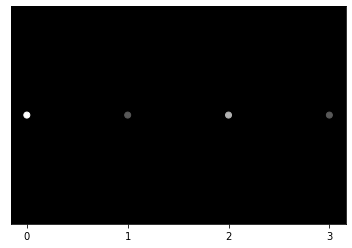

In [88]:
# Experiment 1.a
a = [2,3,3,4]
fft_a = cfft(a)
print(fft_a)

print(cfft(fft_a, inverse=True))

def plot_all(a, fft_a): 
    N = len(a)
    plt.plot(range(N), a, label="f(x)")
    plt.plot(range(N), [_.real for _ in fft_a], label="FFT - Real Part")
    plt.plot(range(N), [_.imag for _ in fft_a], label="FFT - Imaginary Part")
    plt.plot(range(N), [mag(_) for _ in fft_a], label="FFT - Magnitude")
    plt.legend()

# plot_all(a, fft_a)

# TODO: Plot as a B/W graphic
plt.axes(facecolor="black")
plt.scatter(
    range(len(a)),
    y=np.zeros(len(a)),
    c=255 * np.log(np.array([mag(i) for i in fft_a])),
    cmap="gray",
    vmin=0,
    vmax=255
)
plt.xticks(range(4)); plt.yticks([])


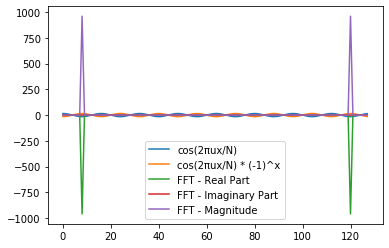

In [38]:
# Experiment 1.b
f = lambda x: cos(2 * pi * 8 * x / 128)
samples = [ f(x) for x in range(128) ]
plt.plot(range(128), samples, label="cos(2πux/N)")

samples_normed = [ f(x) * (-1 ** x) for x in range(128) ]

from matplotlib import pyplot as plt
plt.plot(range(128), samples_normed, label="cos(2πux/N) * (-1)^x")

fft_samples = cfft(samples_normed)

plot_all(samples_normed, fft_samples)

# plt.subplots(ncols=2, nrows=2)

# TODO: Shift magnitude to the center of the frequency domain using f(x) * (-1)^x <-> F(u - N/2)
# Report and justify findings in the report

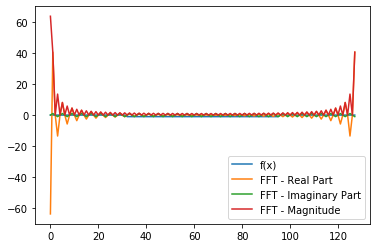

In [45]:
# Experiment 1.c
samples = open('/home/user1316/Downloads/Rect_128.dat').read().splitlines()
samples = [float(s) for s in samples]
samples = [(-1 ** x) * samples[x] for x in range(len(samples))]

plot_all(samples, cfft(samples))

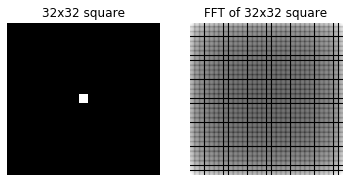

In [100]:
# Experiment 2.a
npl = np.log
npa = np.abs
shift = np.fft.fftshift
ones = np.ones((512,512))

def square_image(sq_sz):
    canvas = np.zeros((512, 512))
    
    for i in range(sq_sz):
        for j in range(sq_sz):
            x = int( 256 - (sq_sz / 2) + i )
            y = int( 256 - (sq_sz / 2) + j )
            canvas[x][y] = 255
                
    p = PGMImage('lenna.pgm')
    p.pixels = canvas
    p.rows = p.cols = 512
    p.truncate()
    p.save(f'square-{sq_sz}.pgm')
    
    return p

def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.
    
    Source: https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window

    :param figures <title, figure> dictionary
    :param ncols number of columns of subplots wanted in the display
    :param nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind, title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()

# sq32 = square_image(32)
fft32 = cfft2(sq32.pixels)
plot_figures({
    "32x32 square": sq32.pixels, "FFT of 32x32 square": npl(np.add(ones, npa(fft32)))
},
1, 2)

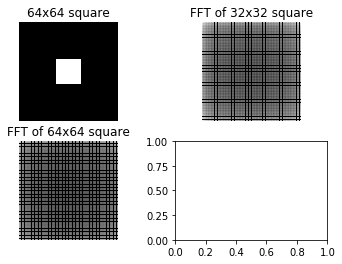

In [98]:
# Experiment 2.b, 2.c
# sq64 = square_image(64)
fft64 = cfft2(sq64.pixels)
# sq128 = square_image(128)
fft128 = cfft2(sq128.pixels)

# TODO: For report, describe analytical solution for rect()
plot_figures(
    {"64x64 square": sq64.pixels,                            "64x64 square": sq128.pixels, 
     "FFT of 32x32 square": npl(np.add(ones, npa(fft64))),   "FFT of 64x64 square": npl(np.add(ones, npa(fft128)))
    }
, 2, 2)

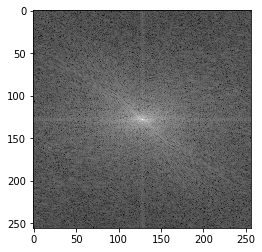

In [81]:
# Experiment 3
p = PGM.PGMImage('lenna.pgm')

a = cfft2(p.pixels)

# TODO: Implement fftshift ourselves
plt.imshow(20 * np.fft.fftshift(np.log(np.abs(a))), cmap = 'gray')

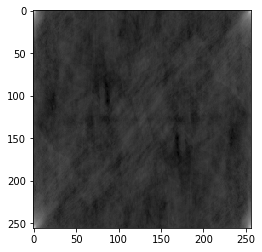

In [86]:
# Experiment 3.a
a = cfft2(p.pixels)

for i in range(len(a)):
    for j in range(len(a[i])):
        a[i][j] = complex(mag(a[i][j]), 0)

a = cfft2(a, inverse=True)

plt.imshow(np.log(np.abs(a)), cmap = 'gray')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


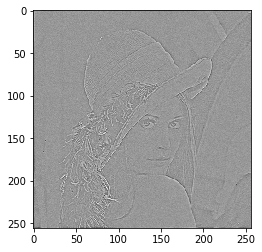

In [89]:
# Experiment 3.b
from math import atan2, cos, sin

a = cfft2(p.pixels)

# TODO: prove that to set the magnitude equal to one, 
# set the real part to cos(theta) 
# and the imaginary part to sin(theta) where theta=tan-1(imag/real)

for i in range(len(a)):
    for j in range(len(a[i])):
        theta = atan2(a[i][j].imag, a[i][j].real)
        a[i][j] = complex(real=cos(theta), imag=sin(theta))

a = np.array(cfft2(a, inverse=True)).astype(float)
        
p2 = PGM.PGMImage('lenna.pgm')
p2.pixels = a
p2.normalize()
plt.imshow(p2.pixels, plt.cm.gray)